In [1]:
%load_ext autoreload
%autoreload 2

In [64]:
import cv2
import numpy as np
import imageio
import os
import matplotlib.pyplot as plt
from skimage.measure import label
from skimage.segmentation import flood, flood_fill, mark_boundaries
from skimage.morphology import medial_axis, skeletonize
from tqdm.notebook import tqdm
import pandas as pd
import pickle

In [3]:
rootdir = "/Users/gimli/cvr/data/microscopy/E_serie"

In [4]:
OUT_DIR = "/Users/gimli/cvr/data/microscopy/E"
os.makedirs(OUT_DIR, exist_ok=True)

In [57]:
tifs = []
for root, subFolders, files in os.walk(rootdir):
    for file in files:
        if file[-4:] == ".tif" or file[-5:] == ".tiff":
            tifs.append(os.path.join(root, file))

# #1 sample

In [6]:
file = tifs[0]
tif = imageio.imread(file).astype(int)

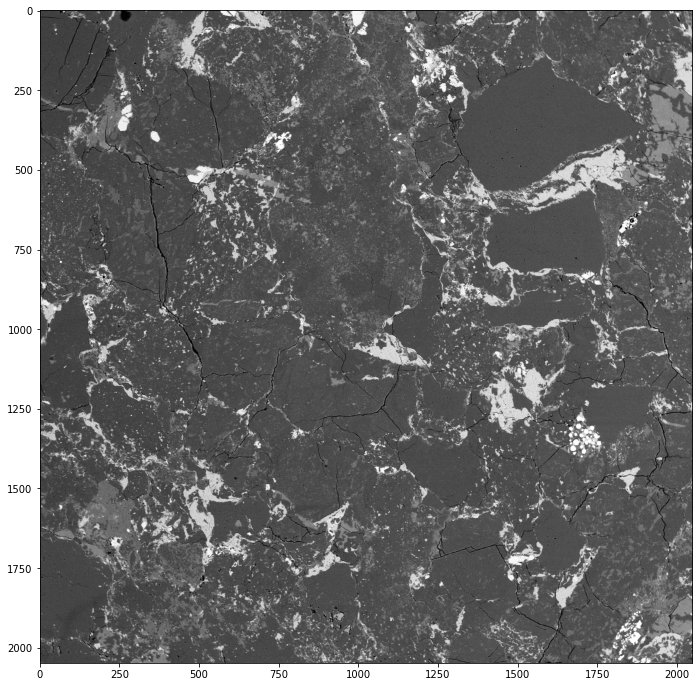

In [8]:
plt.figure(figsize=(12,12))
plt.imshow(tif)
plt.show()

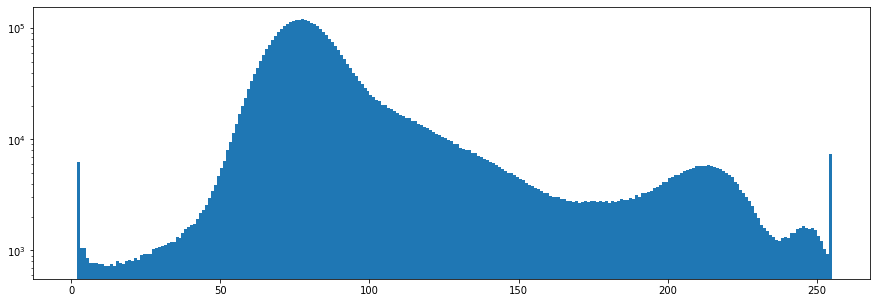

In [11]:
plt.figure(figsize=(15,5))
plt.hist(tif[:,:,0].reshape(-1),bins=np.arange(256))
plt.yscale("log")
plt.show()

In [19]:
mid = np.argmax(np.histogram(tif[:,:,0].reshape(-1),bins=256)[0])
tif[tif <= mid] = tif[tif <= mid] / mid * 95
tif[tif > mid] = (tif[tif > mid] - mid) / (255 - mid) * (255 - 95) + 95

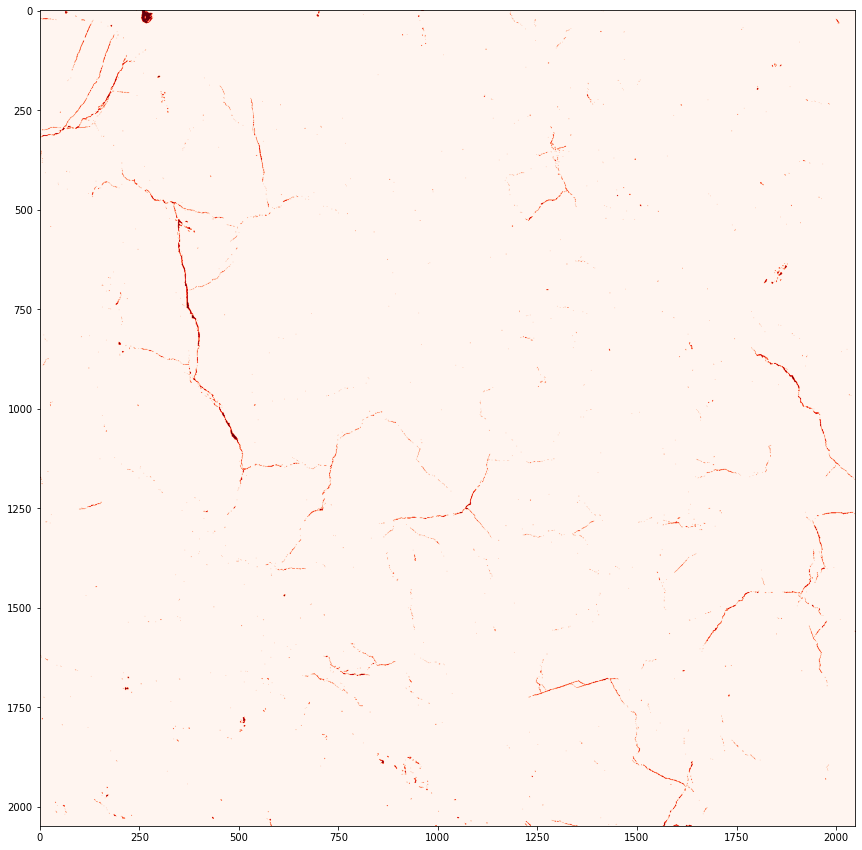

In [41]:
plt.figure(figsize=(15,15))
plt.imshow(tif[:,:,0]<=15, cmap="Reds")
plt.show()

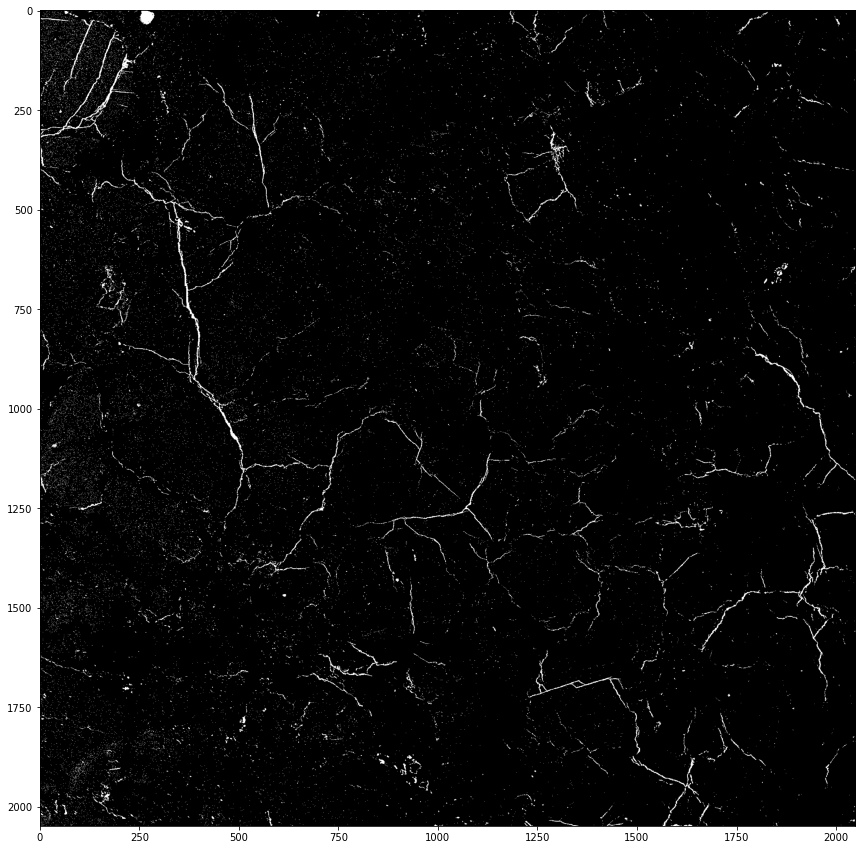

In [34]:
plt.figure(figsize=(15,15))
plt.imshow(tif[:,:,0]<=65, cmap="gray")
plt.show()

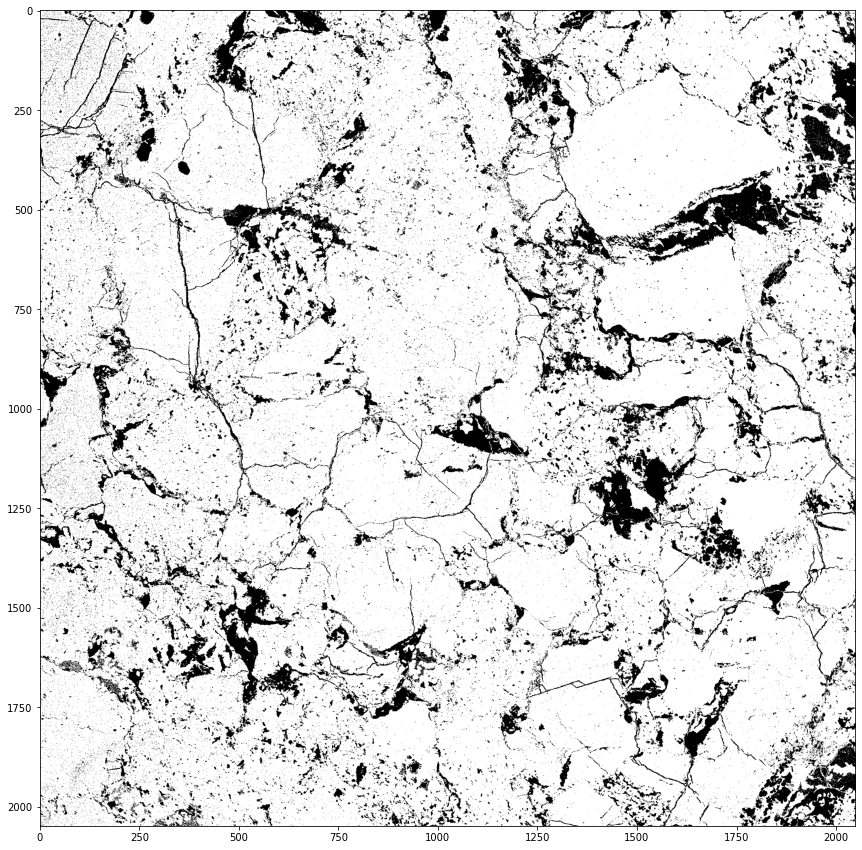

In [36]:
plt.figure(figsize=(15,15))
plt.imshow(np.logical_and(tif[:,:,0]>65, tif[:,:,0]<=140), cmap="gray")
plt.show()

Modrá vs. zelená je nerozlišitelná - zeptat se Patricie jak to detekují. Je tam nějaká morfologie taky.

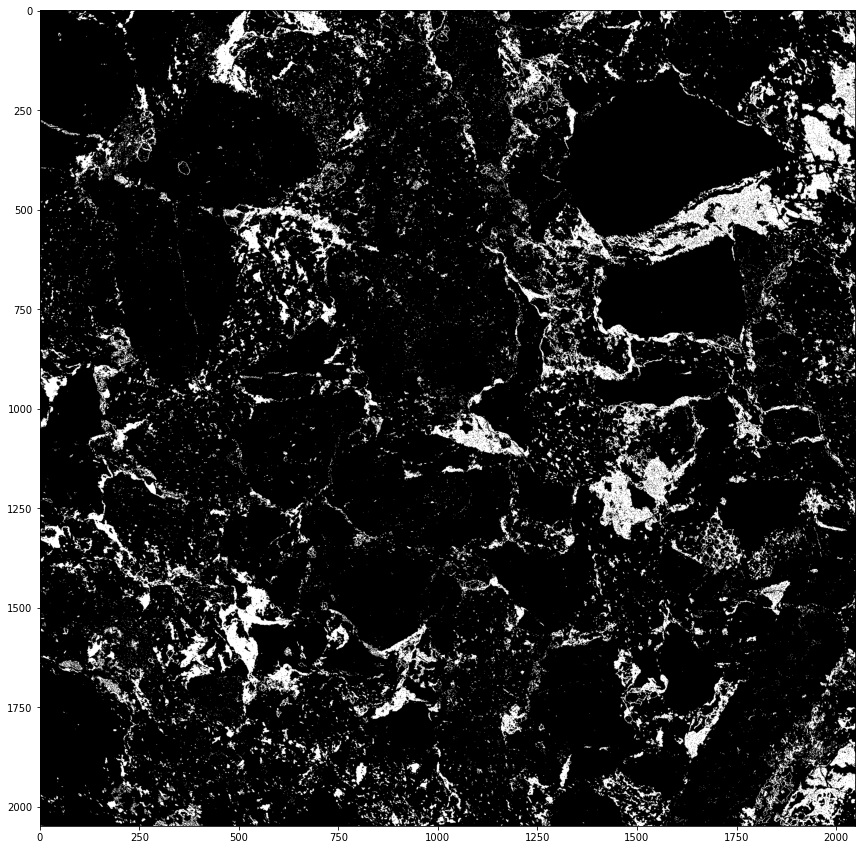

In [35]:
plt.figure(figsize=(15,15))
plt.imshow(np.logical_and(tif[:,:,0]>140, tif[:,:,0]<=230), cmap="gray")
plt.show()

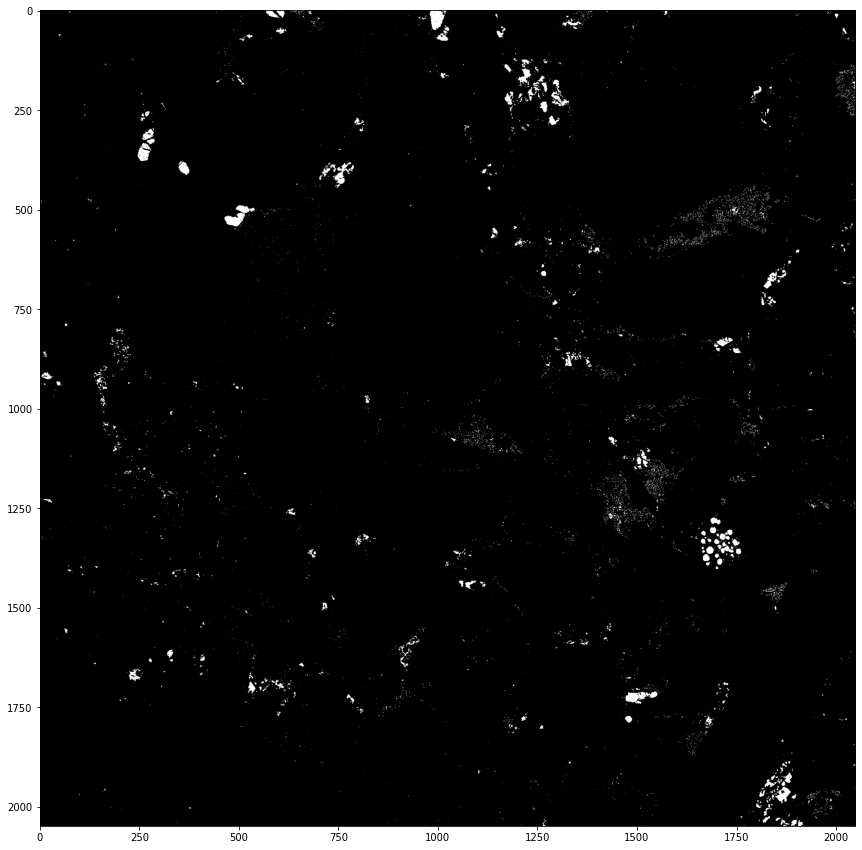

In [37]:
plt.figure(figsize=(15,15))
plt.imshow(tif[:,:,0]>230, cmap="gray")
plt.show()

In [42]:
colored = np.copy(tif[:,:,:])
colored[tif[:,:,0]<=15] = np.array([0,0,0])
colored[np.logical_and(tif[:,:,0]>15, tif[:,:,0]<65)] = np.array([255,50,50])
colored[np.logical_and(tif[:,:,0]>65, tif[:,:,0]<140)] = np.array([200,200,200])
colored[np.logical_and(tif[:,:,0]>140, tif[:,:,0]<230)] = np.array([0,255,50])
colored[tif[:,:,0]>=230] = np.array([255,255,255])

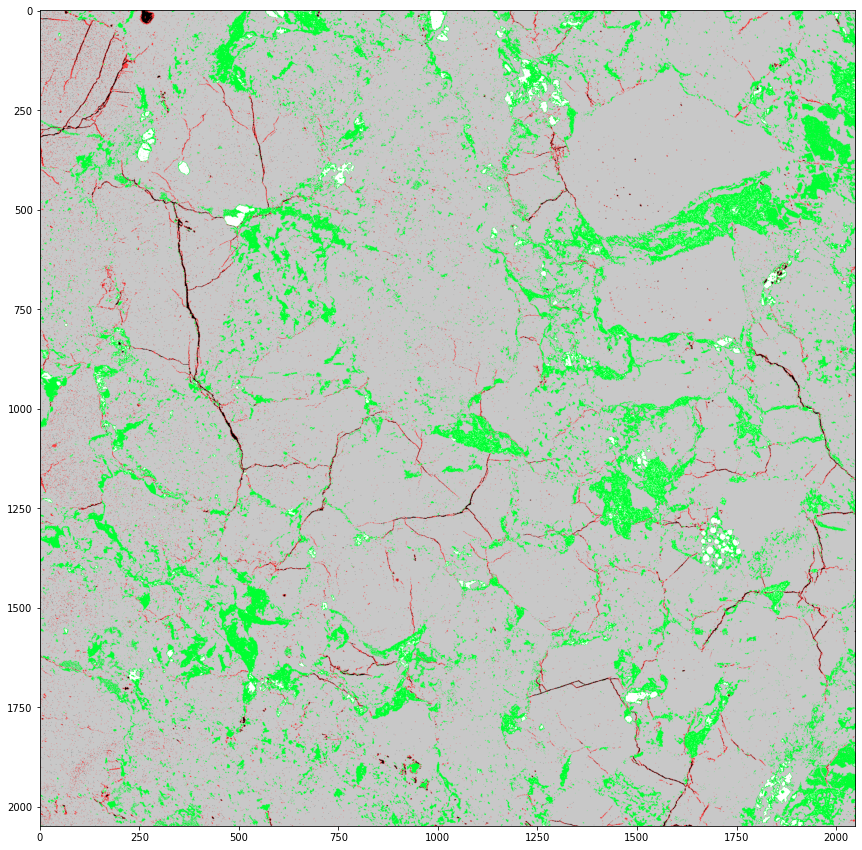

In [43]:
plt.figure(figsize=(15,15))
plt.imshow(colored)
plt.show()

# #Batch

In [170]:
for file in tqdm(tifs[8:9]):
    #if os.path.isfile(file.replace(rootdir, OUT_DIR).replace(".tif", "-cache.pkl")):
    #    continue
    tif = imageio.imread(file).astype(int)
    mid = np.argmax(np.histogram(tif[:,:,0].reshape(-1),bins=256)[0])
    tif[tif <= mid] = tif[tif <= mid] / mid * 95
    tif[tif > mid] = (tif[tif > mid] - mid) / (255 - mid) * (255 - 95) + 95
    colored = np.copy(tif[:,:,:])
    colored[tif[:,:,0]<=15] = np.array([0,0,0])
    colored[np.logical_and(tif[:,:,0]>15, tif[:,:,0]<65)] = np.array([255,50,50])
    colored[np.logical_and(tif[:,:,0]>65, tif[:,:,0]<140)] = np.array([200,200,200])
    colored[np.logical_and(tif[:,:,0]>140, tif[:,:,0]<230)] = np.array([0,255,50])
    colored[tif[:,:,0]>=230] = np.array([255,255,255])
    os.makedirs(os.path.dirname(file).replace(rootdir, OUT_DIR), exist_ok=True)
    imageio.imwrite(file.replace(rootdir, OUT_DIR).replace(".tif", "segmented.png"), colored.astype(np.uint8))
    c = {
        "name": file,
        "tif": tif.astype(np.uint8),
        "cimg": colored.astype(np.uint8)
    }
    pickle.dump(c, open(c["name"].replace(rootdir, OUT_DIR).replace(".tif", "-cache.pkl"), "wb"))

  0%|          | 0/1 [00:00<?, ?it/s]

In [171]:
for tif in tqdm(tifs[8:9]):
    c = pickle.load(open(tif.replace(rootdir, OUT_DIR).replace(".tif", "-cache.pkl"), "rb"))
    seeds = np.where(c["tif"][:,:,0]<=15)
    presegment = np.zeros((c["tif"].shape[0], c["tif"].shape[1]))
    presegment[c["tif"][:,:,0]<65] = 1
    
    for seed in tqdm(zip(seeds[0], seeds[1]), leave=False):
        if presegment[seed[0], seed[1]] == 1:
            presegment = flood_fill(presegment, seed, 2)
    segmented = np.copy(presegment)
    segmented[segmented == 1] = 0
    segmented[segmented == 2] = 1
    c["mask"] = segmented
    pickle.dump(c, open(c["name"].replace(rootdir, OUT_DIR).replace(".tif", "-cache.pkl"), "wb"))
    imageio.imwrite(c["name"].replace(rootdir, OUT_DIR).replace(".tif", "-mask.png"), 
                    (segmented * 255).astype(np.uint8))

  0%|          | 0/1 [00:00<?, ?it/s]

In [144]:
def crack_bounding_box(labels):
    ones = np.where(labels)
    left_top = (np.min(ones[0]), np.min(ones[1]))
    right_bottom = (np.max(ones[0])+1, np.max(ones[1])+1)
    bounding_box = labels[left_top[0]:np.max(ones[0])+1, left_top[1]: np.max(ones[1])+1]
    return bounding_box, left_top

The process of crack skeletonization and marking is now (for speeding it up) made on cropped area. Other step is to use GPU.

In [172]:
for tif in tqdm(tifs[8:9]):
    c = pickle.load(open(tif.replace(rootdir, OUT_DIR).replace(".tif", "-cache.pkl"), "rb"))    
    skeleton, distance = medial_axis(c["mask"], return_distance=True)
    c["skeleton"] = skeleton
    imageio.imwrite(c["name"].replace(rootdir, OUT_DIR).replace(".tif", "-skeleton.png"), 
                    (c["skeleton"] * 255).astype(np.uint8))
    c["labels"] = label(c["mask"])

    bounds = []    
    for l in tqdm(range(1, np.max(c["labels"])), leave=False):
        crack, left_top = crack_bounding_box(c["labels"] == l)
        skeleton, distance = medial_axis(crack, return_distance=True)

        marked = mark_boundaries(
             np.pad(c["mask"][left_top[0]: left_top[0] + crack.shape[0], 
                              left_top[1]: left_top[1] + crack.shape[1]],
                    ((1,1),(1,1))),
             np.pad(crack, ((1,1),(1,1))), 
            outline_color=(0.5,0,0),mode="outer")
        boundary = np.where(marked[:,:,0] == 0.5)
        counter = 0
        for px in boundary:
            if (px[0] + left_top[0] - 1 >= 0 and px[0] + left_top[0] - 1 < c["cimg"].shape[0] and
                px[1] + left_top[1] - 1 >= 0 and px[1] + left_top[1] - 1 < c["cimg"].shape[1] and
                c["cimg"][px[0] + left_top[0] - 1,px[1] + left_top[1] - 1,1] == 255):
                counter += 1
        bounds.append({
            "label": l,
            "size": np.sum(crack),
            "length": np.sum(skeleton),
            "maxWidth": np.max(distance),
            "avgWidth": np.mean(distance[distance != 0]),
            "boundaryLength": len(boundary[0]),
            "precipitates": counter
        })
    
    c["bounds"] = bounds
    pd.DataFrame(c["bounds"]).to_csv(open(tif.replace(rootdir, OUT_DIR).replace(".tif", "-data.csv"), "wt"))
    pickle.dump(c, open(c["name"].replace(rootdir, OUT_DIR).replace(".tif", "-cache.pkl"), "wb"))
    

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/13196 [00:00<?, ?it/s]

Both loops can be parallel, but it is necessary to find out suitable machine.

In [173]:
for tif in tqdm(tifs):
    c = pickle.load(open(tif.replace(rootdir, OUT_DIR).replace(".tif", "-cache.pkl"), "rb"))
    imageio.imwrite(c["name"].replace(rootdir, OUT_DIR).replace(".tif", "-skeleton.png"), 
                    (c["skeleton"] * 255).astype(np.uint8))
    pd.DataFrame(c["bounds"]).to_csv(open(tif.replace(rootdir, OUT_DIR).replace(".tif", "-data.csv"), "wt"))

  0%|          | 0/112 [00:00<?, ?it/s]

In [167]:
tifs[9:10]

['/Users/gimli/cvr/data/microscopy/E_serie/detekce_trhlin_z_BSE_snímků/E07/BSE_images/Electron Image 19.tif']

In [169]:
c = pickle.load(open(tifs[8].replace(rootdir, OUT_DIR).replace(".tif", "-cache.pkl"), "rb"))

EOFError: Ran out of input